# Problema Abordado

## **Image-to-Text: Geração Automática de Legendas para Imagens**

O problema de **image-to-text**, ou geração de legendas para imagens, consiste em transformar automaticamente uma imagem em uma descrição textual que represente seu conteúdo de forma clara e informativa.

### Por que essa tarefa é relevante?

- **Conexão entre visão e linguagem:** Traduzir imagens em texto é um passo crucial para permitir que máquinas compreendam e comuniquem informações visuais, integrando visão computacional e processamento de linguagem natural.

- **Melhora na acessibilidade:** Usuários com deficiência visual podem se beneficiar de descrições automáticas que transmitam o que está presente nas imagens.

- **Facilita a busca e organização:** Sistemas de recuperação de imagens podem utilizar legendas para indexação, melhorando a precisão na busca por conteúdo visual.

- **Base para aplicações avançadas:** Assistentes virtuais, robôs autônomos e sistemas de vigilância podem utilizar legendas geradas automaticamente para interpretar cenas em tempo real.

### Desafios principais

- Compreender o conteúdo visual de forma contextualizada, incluindo objetos, ações e relações.

- Gerar texto natural, coerente e relevante à imagem.

- Integrar efetivamente informações visuais e linguísticas, que possuem representações muito diferentes.

### Nossa abordagem

Este projeto usa um modelo híbrido: um **encoder baseado em redes convolucionais** de autoria propria para extrair características visuais detalhadas e um **decoder GPT-2**, pré-treinado em grandes corpora textuais, para gerar legendas condicionadas à imagem. Essa combinação visa unir a capacidade de representação visual profunda com o poder da geração de linguagem natural.

---

A geração automática de descrições para imagens é um campo em rápido crescimento, com grande potencial para impactar diversas áreas da inteligência artificial e aplicações do cotidiano.


# Implementação

## Importações

In [ ]:
!pip install evaluate

In [ ]:
import torch
from torchvision import transforms, datasets
from torchvision import models
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from datasets import load_dataset
from PIL import Image
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import time


2025-07-01 23:45:29.744194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751413529.902372      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751413529.947785      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Funções Auxiliares

In [ ]:
def train_validate_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()

    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        start_time = time.time()

        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch in train_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions[:, :-1])  # input tokens
            logits = outputs[:, 1:, :]                 # remove predição do prefixo imagem
            targets = captions[:, 1:]                  # tokens a serem previstos

            # Loss
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Acurácia por token (ignora padding)
            predictions = logits.argmax(dim=-1)        # shape: (B, T)
            mask = targets != 50256                    # 50256 = <eos>, usado como padding
            correct = ((predictions == targets) & mask).sum().item()
            total = mask.sum().item()

            epoch_correct += correct
            epoch_total += total

        # Fim da época
        acc = epoch_correct / epoch_total if epoch_total > 0 else 0.0
        avg_loss = epoch_loss / len(train_loader)
        avg_test_loss = evaluate_model(model, test_loader, device, criterion)
        train_losses.append(avg_loss)
        test_losses.append(avg_test_loss)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Test Loss: {avg_test_loss:.4f} - Acc: {acc:.4f} - Time: {elapsed:.2f}s")

    return train_losses, test_losses


In [ ]:
def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    total_loss = 0.0


    with torch.no_grad():
        for batch in test_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            outputs = model(images, captions[:, :-1])
            logits = outputs[:, 1:, :]
            targets = captions[:, 1:]
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)



    return avg_loss

In [ ]:
#Função para ajustar dimensões dos tensores do dataset

def collate_fn(batch):
    # Extrai cada campo do batch
    images = [item["image_tensor"] for item in batch]
    captions = [item["caption"] for item in batch]
    input_ids = [item["tokenized_caption"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    images_orig = [item["image_original"] for item in batch]

    # Empilha as imagens (todas já têm o mesmo shape, então stack direto)
    image_tensor = torch.stack(images)

    # Faz padding nas sequências de texto
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=50256)  # eos_token_id para GPT-2
    attention_mask_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "image_tensor": image_tensor,                    # (B, 3, 224, 224)
        "caption": captions,                             # Lista de strings
        "tokenized_caption": input_ids_padded,           # (B, T)
        "attention_mask": attention_mask_padded,         # (B, T)
        "image_original": images_orig                    # Lista de PIL Images
    }


In [ ]:
def generate_caption(model, image_tensor, tokenizer, max_length=30, device="cuda"):
    model.eval()

    with torch.no_grad():
        # Extrai vetor da imagem
        image_tensor = image_tensor.unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)
        image_features = model.encoder(image_tensor)         # (1, 256)
        img_embed = model.decoder.image_proj(image_features).unsqueeze(1)  # (1, 1, 768)

        # Começa com token vazio
        input_ids = torch.tensor([[tokenizer.bos_token_id or tokenizer.eos_token_id]], device=device)

        # Lista de embeddings: começa com imagem
        generated = img_embed

        for _ in range(max_length):
            # Embedding do texto gerado até agora
            text_embeds = model.decoder.gpt.transformer.wte(input_ids)
            gpt_input = torch.cat([img_embed, text_embeds], dim=1)

            attention_mask = torch.ones(gpt_input.shape[:2], device=device)

            outputs = model.decoder.gpt(inputs_embeds=gpt_input, attention_mask=attention_mask)
            next_token_logits = outputs.logits[:, -1, :]  # último token
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            if next_token.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token], dim=-1)

        caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return caption

In [ ]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')

    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import random
import evaluate
import matplotlib.pyplot as plt

# Carrega a métrica BLEU
bleu_metric = evaluate.load("bleu")

def visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device):
    model.eval()

    # Pegar uma amostra aleatória do test_loader
    all_batches = list(test_loader)
    batch = random.choice(all_batches)
    idx = random.randint(0, len(batch["image_tensor"]) - 1)

    image_tensor = batch["image_tensor"][idx].to(device)
    image_pil = batch["image_original"][idx]
    real_caption = batch["caption"][idx]

    # Gerar legenda com o modelo
    with torch.no_grad():
        pred_caption = generate_caption(model, image_tensor, tokenizer, device=device)

    # Calcular BLEU
    bleu_score = bleu_metric.compute(predictions=[pred_caption], references=[[real_caption]])["bleu"]

    # Exibir imagem + legendas + BLEU
    plt.imshow(image_pil)
    plt.axis("off")
    plt.title("Exemplo aleatório do conjunto de teste")
    plt.show()

    print(f"Legenda real:     {real_caption}")
    print(f"Legenda gerada:   {pred_caption}")
    print(f"Score BLEU:       {bleu_score:.4f}")


In [ ]:
from tqdm import tqdm
import seaborn as sns


def avaliar_bleu_aleatorio(model, test_loader, tokenizer, device, n_amostras=300):
    model.eval()
    bleu_scores = []

    # Junta todos os batches em uma lista
    all_batches = list(test_loader)

    with torch.no_grad():
        for _ in tqdm(range(n_amostras)):
            # Amostra aleatória
            batch = random.choice(all_batches)
            idx = random.randint(0, len(batch["image_tensor"]) - 1)

            image_tensor = batch["image_tensor"][idx].to(device)
            real_caption = batch["caption"][idx]

            # Geração
            pred_caption = generate_caption(model, image_tensor, tokenizer, device=device)

            # BLEU individual
            score = bleu_metric.compute(predictions=[pred_caption], references=[[real_caption]])["bleu"]
            bleu_scores.append(score)

    # Estatísticas
    media_bleu = np.mean(bleu_scores)
    desvio = np.std(bleu_scores)

    print(f"\n📊 Média dos scores BLEU (n={n_amostras}): {media_bleu:.4f} ± {desvio:.4f}")

    # Gráfico com distribuição normal
    plt.figure(figsize=(10, 5))
    sns.histplot(bleu_scores, bins=30, kde=True, color="skyblue", stat="density", edgecolor="black")

    # Linha da média
    plt.axvline(media_bleu, color='red', linestyle='--', label=f"Média: {media_bleu:.4f}")
    plt.title("Distribuição dos scores BLEU")
    plt.xlabel("Score BLEU")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)
    plt.show()

# Conjunto de Dados: DeepFashion

O conjunto de dados utilizado para o treinamento do modelo foi o **DeepFashion**, uma base amplamente utilizada em tarefas de **Image to Text**.

### Visão Geral

- **Tamanho**: Cerca de **44,096 imagens** Para a execução desse trabalho foram utilizadas apenas 3000 imagens
- **Formato das imagens**: RGB, com alta variedade de poses, planos e fundos
---
![Visão geral do dataset](https://github.com/yumingj/DeepFashion-MultiModal/raw/main/assets/dataset_overview.png)
---
### Subconjunto Utilizado

Para o problema de **Image to Text**, foi utilizado o subconjunto com **descrições curtas de roupas**. Cada exemplo consiste em:

- **Entrada**: imagem de uma peça de roupa
- **Saída**: legenda textual que descreve a peça


---

### Pré-processamento

As seguintes etapas de pré-processamento foram realizadas:

- **Redimensionamento das imagens** para um tamanho fixo (por exemplo, `224x224` pixels), necessário para o encoder convolucional.
- **Normalização** dos pixels com média e desvio padrão de `ImageNet`, garantindo compatibilidade com redes pré-treinadas.
- **Tokenização dos textos** com o tokenizer do GPT-2 (subword), transformando legendas em tensores numéricos compatíveis com o decoder.

---

### Data Augmentation

Foram utilizadas técnicas leves de *data augmentation* durante o treinamento para aumentar a variabilidade e reduzir o overfitting:

- **Flip horizontal aleatório**
- **Crop e resize aleatório**
- **Jitter de brilho/contraste**

#### Benefícios:

- Ajuda o modelo a **generalizar** para diferentes poses e iluminações
- Melhora o desempenho em imagens reais fora do dataset

---

### Conclusão e comentários

O DeepFashion oferece um excelente ponto de partida para modelos de **Image To Text**, por sua variedade e riqueza visual. A combinação de imagens realistas e descrições textuais curtas permite o treinamento de modelos robustos para geração de legendas com compreensão semântica de roupas e moda.

Para este trabalho, selecionamos aleatoriamente 3.000 imagens da base DeepFashion-MultiModal. Essa escolha foi motivada, principalmente, pelas limitações de hardware e tempo disponíveis para o desenvolvimento do projeto. Com isso, nosso objetivo foi alcançar resultados de caráter didático, utilizando uma amostra reduzida da base original.

No entanto, é importante destacar que essa decisão pode introduzir algumas limitações. A seleção aleatória pode resultar em uma distribuição desequilibrada das categorias de roupas, reduzindo a representatividade de determinados tipos de vestuário no conjunto de dados. Isso pode comprometer a capacidade do modelo de generalizar sobre certos padrões visuais. Por exemplo, se houver apenas uma imagem representando uma jaqueta de couro, o modelo não terá amostras suficientes para aprender suas características visuais de forma eficaz.




### Carregando o dataset


O DeepFashionDataset utiliza o GPT2Tokenizer como tokenizador padrão para converter as descrições textuais em tokens numéricos compatíveis com o modelo GPT-2. Como esse modelo não possui um token de padding nativo, o pad_token é manualmente ajustado para o eos_token, permitindo o uso de padding dinâmico no DataLoader. Para isso, a tokenização é feita sem truncamento direto na amostra, e o padding é tratado posteriormente por meio de uma função personalizada collate_fn, que uniformiza o tamanho das sequências dentro de cada batch, garantindo que todas tenham o mesmo comprimento durante o treinamento.

In [ ]:


class DeepFashionDataset(Dataset):
    def __init__(self, labelDataset, image_dir, transform=None, tokenizer=None):
        self.df = labelDataset.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Tokenizador padrão: GPT-2
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token  # GPT-2 não tem pad_token original

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        caption = row["caption"]
        img_path = os.path.join(self.image_dir, row["path"].replace("\\", "/"))
        img_path = os.path.normpath(img_path)
        # Imagem original e transformada
        image_pil = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image_pil) if self.transform else image_pil

        # Tokenização (sem truncamento, padding tratado no collate_fn no Dataloader)
        tokens = self.tokenizer(caption, return_tensors="pt")
        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        return {
            "image_tensor": image_tensor,
            "caption": caption,
            "tokenized_caption": input_ids,
            "attention_mask": attention_mask,
            "image_original": image_pil
        }



Esse transform aplica uma série de pré-processamentos e aumentos de dados nas imagens. Ele redimensiona, realiza cortes e espelhamentos aleatórios para aumentar a variedade dos dados, além de ajustar brilho e contraste. Por fim, converte a imagem em tensor e normaliza os valores com as médias e desvios usados em modelos treinados com ImageNet. O objetivo desse transform é padronizar e aumentar a variedade das imagens para melhorar a generalização do modelo durante o treinamento.

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),                 # Redimensiona para 224x224
    transforms.RandomHorizontalFlip(p=0.5),        # Flip horizontal com 50% de chance
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop aleatório e resize para 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Ajusta brilho e contraste
    transforms.ToTensor(),                          # Converte PIL Image para tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalização ImageNet
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
labels_df = pd.read_csv('/kaggle/input/deep-fashion-datasets/labels_front.csv')
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12278 entries, 0 to 12277
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      12278 non-null  object
 1   caption       12278 non-null  object
 2   path          12278 non-null  object
 3   gender        12278 non-null  object
 4   product_type  12278 non-null  object
 5   product_id    12278 non-null  object
 6   image_type    12278 non-null  object
dtypes: object(7)
memory usage: 671.6+ KB


In [ ]:
labels_df['image_id'].head()
labels_df["image_id"] = labels_df["image_id"].str.replace(r"\.jpg$", "", regex=True) + ".jpg"


Aqui o dataset é filtrado para conter apenas 3000 imagens


In [ ]:
# Filtrar o DataFrame mantendo apenas image_ids que estão presentes na pasta
images_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images"
available_images = set(os.listdir(images_dir))
labels_df = labels_df[labels_df["image_id"].isin(available_images)].reset_index(drop=True)
labels_df = labels_df.sample(n=3000, random_state=42).reset_index(drop=True)


### Data Loader

In [ ]:
dataset = DeepFashionDataset(
    labelDataset = labels_df,
    image_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images",
    transform = transforms
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 16 #Quantos exemplos são processsados juntos durante o treino
#Como não estamos truncando o tamanho dos tokens precisamos garantir que todas as legendas
# tenham o mesmo tamanho de tensor o collate_fn ajustara esse tamanho com

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Rede Implementada

## Arquitetura do Encoder

A classe `Encoder` implementa uma rede neural convolucional profunda que extrai características de imagens RGB (3 canais) e projeta essas características em um espaço vetorial de dimensão fixa (`output_dim`, padrão: 256). Essa arquitetura é útil para tarefas de extração de embeddings ou como backbone em modelos maiores.

### Estrutura da Rede

A rede é composta por quatro blocos convolucionais seguidos por uma camada de projeção totalmente conectada:

#### Blocos Convolucionais

Cada bloco contém:

- Uma camada `Conv2d` com `kernel_size=3`, `stride=1` e `padding=1` para preservar a resolução espacial.
- Normalização em lote (`BatchNorm2d`) para estabilizar o treinamento.
- Função de ativação `ReLU` para não-linearidade.
- `MaxPool2d(2, 2)` para reduzir a resolução espacial pela metade.

Resumo dos blocos:

| Bloco | Entrada              | Saída                | Operações                                                        |
|-------|----------------------|-----------------------|------------------------------------------------------------------|
| 1     | 3 × 224 × 224        | 32 × 112 × 112        | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 2     | 32 × 112 × 112       | 64 × 56 × 56          | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 3     | 64 × 56 × 56         | 128 × 28 × 28         | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 4     | 128 × 28 × 28        | 256 × 1 × 1           | Conv2d → BatchNorm → ReLU → AdaptiveAvgPool2d(1 × 1)             |

#### Camada de Projeção

Após os blocos convolucionais:

- O tensor 4D de saída (batch_size, 256, 1, 1) é achatado (`view`) para um vetor de dimensão 256.
- Passa por uma `Linear(256, output_dim)` para projeção no espaço de embedding final.

### Diagrama de Fluxo

```text
Input (3xHxW)
   ↓
[Conv2d → BatchNorm → ReLU → MaxPool] × 4
   ↓
AdaptiveAvgPool2d (1x1)
   ↓
Flatten
   ↓
Linear (256 → output_dim)
   ↓
Output: Tensor (batch_size, output_dim)
```

### Ideação da rede
Iniciamos o projeto utilizando um modelo ResNet-50 pré-treinado, visando aproveitar seu alto desempenho em tarefas de visão computacional. No entanto, com o objetivo de exercitar a implementação manual de uma rede neural convolucional (CNN) e explorar, na prática, possíveis desafios de arquitetura e treinamento, optamos por mudar a abordagem. Implementamos uma CNN mais compacta, adequada às limitações de hardware disponíveis, buscando uma estrutura que fosse treinável de forma eficiente. Apesar de reconhecermos que arquiteturas consolidadas como ResNet-50, VGG ou outras redes treinadas no ImageNet — combinadas com fine-tuning — seriam mais eficazes em termos de desempenho, escolhemos seguir com uma CNN manual como parte do processo de aprendizado e aprofundamento técnico.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()

        # Camadas convolucionais
        self.features = nn.Sequential(
            # Bloco 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Projeção para a dimensão desejada
        self.projection = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.projection(x)
        return x



## Arquitetura do Decoder: `Gpt2Decoder`

A classe `Gpt2Decoder` implementa um decodificador baseado no modelo pré-treinado **GPT-2**, modificado para receber **características visuais** como prefixo de entrada textual. Esse módulo é ideal para tarefas de geração de texto condicionada à imagem, como **image captioning** ou **visual storytelling**.

### Estrutura da Rede

O `Gpt2Decoder` realiza os seguintes passos:

1. **Carregamento do GPT-2**:
   - Utiliza o modelo `GPT2LMHeadModel` da biblioteca Hugging Face.
   - Todos os pesos do GPT-2 são congelados, exceto:
     - As **últimas 4 camadas do transformador** (`h[-4:]`).
     - A **cabeça de linguagem** (`lm_head`), responsável pela predição dos tokens.

2. **Projeção das Características Visuais**:
   - Um `Linear(image_dim, n_embd)` projeta o vetor de características da imagem (`image_features`) para o espaço de embeddings do GPT-2.

3. **Token Embedding**:
   - Os `textTokens` (tokens de entrada) são convertidos em embeddings por meio da tabela `wte` do GPT-2.

4. **Concatenação**:
   - O embedding da imagem (1 vetor) é **concatenado** na frente da sequência de embeddings do texto.
   - Isso permite que a imagem seja interpretada como um *token prefixo* pelo modelo.

5. **Máscara de Atenção**:
   - Uma máscara binária é construída:
     - `1` para tokens válidos e o prefixo (imagem).
     - `0` para o token especial de padding (`50256`).

6. **Decodificação com GPT-2**:
   - O modelo recebe os embeddings concatenados e a máscara de atenção.
   - A saída são os **logits** preditivos para os próximos tokens na sequência.

### Diagrama de Fluxo

```text
image_features (B, image_dim)
   ↓
Linear → (B, n_embd)
   ↓
Unsqueeze → (B, 1, n_embd)
   ↓
GPT-2 token embeddings (B, T, n_embd)
   ↓
Concat [image_embed | text_embed] → (B, T+1, n_embd)
   ↓
Attention mask [1 | mask(text)] → (B, T+1)
   ↓
GPT-2 Transformer
   ↓
Output logits (B, T+1, vocab_size)


In [ ]:
class Gpt2Decoder(nn.Module):
    def __init__(self, image_dim=256):
        super().__init__()
        self.gpt = GPT2LMHeadModel.from_pretrained("gpt2")


        for param in self.gpt.parameters():
            param.requires_grad = False

        for param in self.gpt.transformer.h[-4:].parameters():
            param.requires_grad = True
        for param in self.gpt.lm_head.parameters():
            param.requires_grad = True

        self.image_proj = nn.Linear(image_dim, self.gpt.config.n_embd)

    def forward(self, textTokens, image_features):
        batch_size = textTokens.size(0)


        img_embed = self.image_proj(image_features).unsqueeze(1)


        text_embeds = self.gpt.transformer.wte(textTokens)

        gpt_input = torch.cat([img_embed, text_embeds], dim=1)

        attention_mask = (textTokens != 50256).float()
        prefix_mask = torch.ones(batch_size, 1, dtype=attention_mask.dtype,
                               device=attention_mask.device)
        full_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        outputs = self.gpt(inputs_embeds=gpt_input, attention_mask=full_attention_mask)
        return outputs.logits


## Modelo Final: `ImageCaptionModel`

A classe `ImageCaptionModel` implementa um modelo completo de **captionamento de imagens** combinando um **encoder convolucional** para extrair características visuais e um **decoder baseado no GPT-2** para gerar descrições em linguagem natural.

### Arquitetura Geral

O modelo é dividido em dois componentes principais:

1. **Encoder (CNN)**: Extrai um vetor de características compactas da imagem.
2. **Decoder (GPT-2)**: Gera uma legenda textual condicionada à imagem.




In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder_output_dim=256):
        super().__init__()
        self.encoder = Encoder(output_dim=encoder_output_dim)

        self.decoder = Gpt2Decoder(image_dim=encoder_output_dim)

    def forward(self, images, captions):
        image_features = self.encoder(images)
        logits = self.decoder(captions, image_features)
        return logits

# Função de Perda e Otimizador no Treinamento de Modelos de Captionamento de Imagens

Neste projeto, utilizamos um modelo de captionamento de imagens que combina uma rede convolucional como encoder e o GPT-2 como decoder. O processo de treinamento requer escolhas cuidadosas da função de perda e do otimizador, que devem ser compatíveis com a natureza sequencial e multimodal do problema. Abaixo, detalhamos as escolhas feitas e justificamos seu uso.

## Função de Perda: `CrossEntropyLoss`

A tarefa de captionamento de imagem é, essencialmente, um problema de **modelagem de linguagem condicional**: dado um vetor de características da imagem, o modelo deve prever a sequência de palavras que descreve essa imagem.

Para isso, utilizamos a função de perda `nn.CrossEntropyLoss`, que é apropriada para tarefas de **classificação de próximo token**. Em cada passo da geração, o modelo produz uma distribuição de probabilidade sobre o vocabulário, e a perda mede o quão distante essa distribuição está do próximo token verdadeiro da legenda.

```python
criterion = nn.CrossEntropyLoss(ignore_index=50256)
```

### Justificativas:

* É a escolha padrão para modelos de linguagem como o GPT-2.
* Permite o cálculo da perda token a token, agregando o erro ao longo da sequência.
* O parâmetro `ignore_index=50256` evita penalizar o modelo por prever o token de padding (`<|endoftext|>` do GPT-2), o que é importante para lidar com legendas de comprimentos variáveis.

Essa função de perda assegura que o modelo aprenda a gerar sequências linguisticamente coerentes e semanticamente alinhadas com o conteúdo da imagem.

---

## Otimizador: `Adam`

O otimizador adotado foi o **Adam** (`torch.optim.Adam`), que combina as vantagens da descida de gradiente com momento e adaptação de taxa de aprendizado.

```python
optimizer = optim.Adam(model.parameters(), lr=1e-4)
```

### Justificativas:

* O Adam é eficaz para redes profundas, pois ajusta individualmente a taxa de aprendizado de cada parâmetro.
* A combinação de momentum e normalização por segundo momento é especialmente útil para estabilizar o treinamento de modelos grandes como o GPT-2.
* A taxa de aprendizado `1e-4` é moderada, apropriada para **fine-tuning** de modelos pré-treinados, como é o caso aqui.

Ademais, como o modelo congela parte do GPT-2 (exceto as últimas camadas e a lm\_head), o otimizador atuará principalmente sobre:

* O encoder convolucional, que é treinado do zero.
* As últimas camadas do decoder, que serão ajustadas para integrar eficientemente a informação visual ao texto gerado.

---

## Conclusão

A combinação de `CrossEntropyLoss` com `Adam` forma uma base sólida e bem estabelecida para o treinamento de modelos de linguagem natural condicionados por imagem. Enquanto a perda guia o modelo a produzir sequências coerentes, o otimizador garante uma atualização estável e eficiente dos pesos.

Essas escolhas estão alinhadas com boas práticas da literatura recente em vision-language modeling e são adequadas para obter bons resultados em tarefas como image captioning.


In [ ]:
device = torch.device("cuda")
model = ImageCaptionModel().to(device)


criterion = nn.CrossEntropyLoss(ignore_index=50256)  # Ignora padding tokens
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Treinamento da Rede

Durante o treinamento da rede, foram realizados diversos testes exploratórios. Observamos que a simples redução do número de imagens, mesmo acompanhada por um aumento no número de épocas, tende a ser menos eficaz do que trabalhar com um conjunto maior de imagens, ainda que com menos épocas. Com base nessa análise, optamos pelo teste final utilizando 3.000 imagens e 20 épocas, buscando garantir a convergência do modelo. Inicialmente, acreditamos que esse cenário seria suficiente, uma vez que a perda (loss) apresentava queda constante e a acurácia se mantinha elevada. No entanto, como será discutido nas seções seguintes, essa suposição será reavaliada e contestada com base em uma análise mais aprofundada dos resultados.

In [ ]:

train_losses, test_losses = train_validate_model(model, train_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20 - Train Loss: 0.4503 - Test Loss: 0.4006 - Acc: 0.8188 - Time: 99.04s
Epoch 2/20 - Train Loss: 0.3833 - Test Loss: 0.3790 - Acc: 0.8345 - Time: 98.24s
Epoch 3/20 - Train Loss: 0.3698 - Test Loss: 0.3758 - Acc: 0.8391 - Time: 98.41s
Epoch 4/20 - Train Loss: 0.3582 - Test Loss: 0.3724 - Acc: 0.8431 - Time: 98.10s
Epoch 5/20 - Train Loss: 0.3495 - Test Loss: 0.3678 - Acc: 0.8483 - Time: 97.70s
Epoch 6/20 - Train Loss: 0.3402 - Test Loss: 0.3715 - Acc: 0.8510 - Time: 97.86s
Epoch 7/20 - Train Loss: 0.3298 - Test Loss: 0.3712 - Acc: 0.8559 - Time: 98.69s
Epoch 8/20 - Train Loss: 0.3192 - Test Loss: 0.3724 - Acc: 0.8603 - Time: 98.65s
Epoch 9/20 - Train Loss: 0.3059 - Test Loss: 0.3851 - Acc: 0.8662 - Time: 101.13s
Epoch 10/20 - Train Loss: 0.2912 - Test Loss: 0.3984 - Acc: 0.8728 - Time: 100.90s
Epoch 11/20 - Train Loss: 0.2724 - Test Loss: 0.4189 - Acc: 0.8818 - Time: 98.98s
Epoch 12/20 - Train Loss: 0.2525 - Test Loss: 0.4422 - Acc: 0.8901 - Time: 98.57s
Epoch 13/20 - Train Los

In [ ]:

torch.save(model.state_dict(), "modelo_treinado.pth")


# Qualidade dos Resultados

A análise dos resultados de treino e validação ao longo das 20 épocas revela pontos importantes sobre o comportamento do modelo. O principal aspecto positivo é a queda consistente da loss de treino, indicando que a rede está aprendendo a representar bem os dados que vê. Além disso, a acurácia no conjunto de teste aumenta progressivamente, ultrapassando 94%, o que demonstra uma boa capacidade de acerto nos tokens previstos.

No entanto, há um problema evidente de overfitting: a loss de teste começa a subir após a época 8, enquanto a de treino continua caindo. Isso indica que o modelo está memorizando os dados de treino e perdendo generalização para novos exemplos. Mesmo com a acurácia alta, o aumento da perda sugere que as predições tornam-se menos confiáveis e mais repetitivas ou desbalanceadas.

Como estratégia de melhoria, recomenda-se aplicar regularização, como dropout adicional ou aumento da taxa existente, e considerar early stopping em torno da época 8. Também é possível aplicar data augmentation mais agressivo. Outra alternativa seria utilizar validação cruzada para avaliar a consistência do modelo em diferentes subconjuntos do dataset.

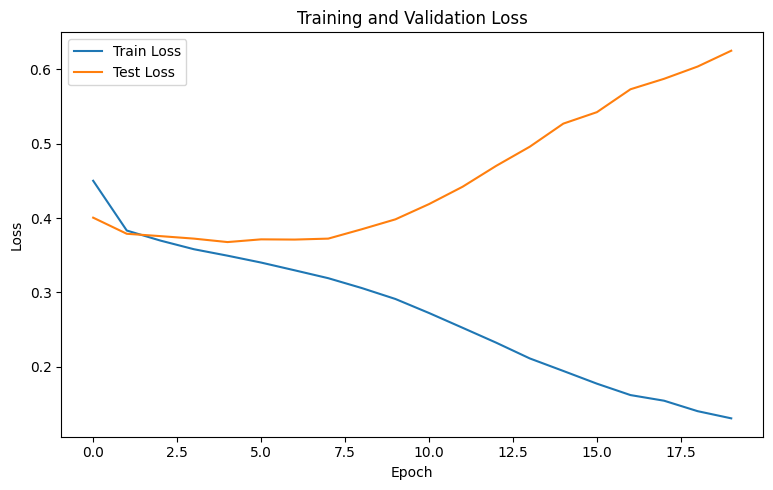

In [ ]:
plot_losses(train_losses, test_losses)

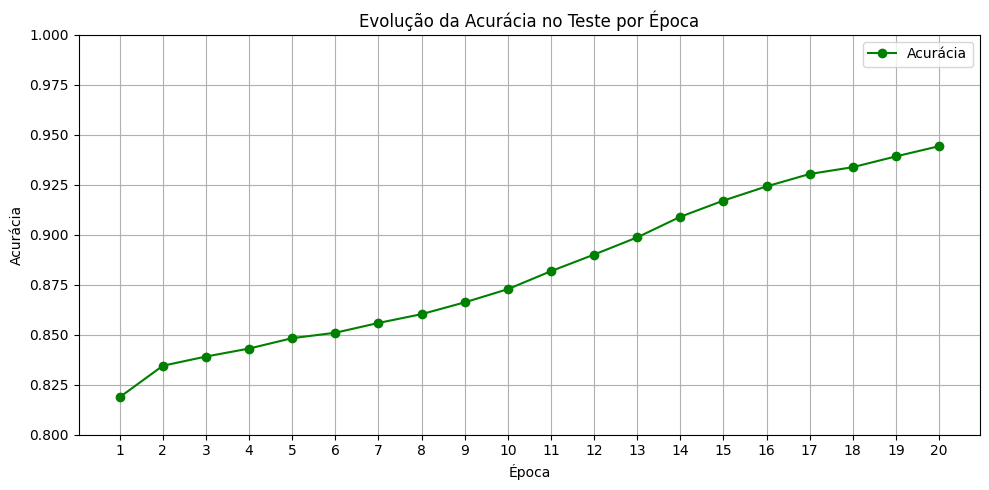

In [ ]:

# Acurácias por época
accs = [
    0.8188, 0.8345, 0.8391, 0.8431, 0.8483,
    0.8510, 0.8559, 0.8603, 0.8662, 0.8728,
    0.8818, 0.8901, 0.8987, 0.9090, 0.9171,
    0.9242, 0.9304, 0.9338, 0.9392, 0.9443
]

epochs = list(range(1, len(accs) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, accs, marker='o', linestyle='-', color='green', label='Acurácia')
plt.title("Evolução da Acurácia no Teste por Época")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.ylim(0.8, 1.0)
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


O valor de acurácia pode ser enganoso se interpretado isoladamente. A acurácia avalia apenas se cada token previsto individualmente corresponde ao token alvo, sem considerar o significado global da sentença gerada. Em tarefas de geração de texto, como a legenda de imagens, a coerência, fluidez e fidelidade semântica da frase são muito mais importantes do que a simples correspondência token a token.

Ao se tratar de uma tarefa de NLP, utilizar métricas específicas para o entendimento da qualidade do texto é fundamental. Pensando nisso, nosso grupo buscou explorar também a métrica BLEU, que mede a sobreposição de n-gramas entre a frase gerada e a referência, oferecendo uma estimativa mais precisa da qualidade linguística e semântica da legenda produzida. Isso permite identificar situações em que a legenda está correta em essência, mesmo com pequenas variações na escolha de palavras.

100%|██████████| 300/300 [01:26<00:00,  3.49it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



📊 Média dos scores BLEU (n=300): 0.1108 ± 0.0983


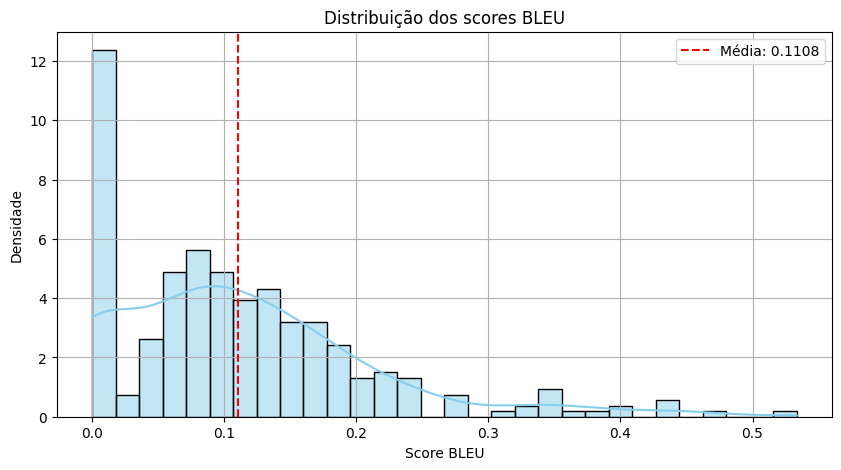

In [ ]:
avaliar_bleu_aleatorio(model, test_loader, tokenizer, device)


A média dos scores BLEU obtidos para 300 amostras foi de 0.1108, com um desvio padrão de 0.0983, indicando uma distribuição bastante concentrada em valores baixos. O gráfico de densidade mostra que grande parte das previsões geradas obteve BLEU próximo de zero, refletindo uma baixa sobreposição entre as legendas produzidas pelo modelo e as descrições reais. Embora o modelo apresente alta acurácia token a token, o baixo desempenho em BLEU sugere que as frases geradas tendem a ser sintaticamente pobres ou semanticamente distantes das esperadas. Isso evidencia que, mesmo com tokens corretos isoladamente, a estrutura geral das legendas ainda carece de coerência e fidelidade contextual, reforçando a importância de métricas específicas de NLP para avaliar a qualidade textual de forma mais adequada e a baixa qualidade do modelo para a geração de legendas.

### Analise caso a caso


Observamos que o modelo foi capaz de gerar frases com coerência sintática, ou seja, as legendas produzidas fazem sentido e não se resumem a palavras soltas ou desconexas. Acreditamos que esse resultado foi alcançado principalmente pelo uso do modelo GPT-2 pré-treinado, aliado a um processo de fine-tuning. Por já ser um modelo robusto para geração de texto, o GPT-2 contribuiu significativamente para a fluidez das frases. Além disso, a estratégia de arquitetura encoder-decoder mostrou-se funcional, permitindo que os textos gerados se relacionassem com o conteúdo visual, descrevendo pessoas e suas roupas com certo grau de consistência.

No entanto, apesar dessas qualidades, os resultados ainda estão aquém do esperado. O modelo não consegue gerar descrições suficientemente próximas das legendas reais, o que se reflete em scores BLEU baixos. É possível notar, por exemplo, que o modelo não distingue com precisão o gênero das pessoas (homens e mulheres) e falha ao identificar corretamente as roupas presentes nas imagens. Esses erros, observados nos exemplos analisados, podem ter origem tanto no número limitado de épocas de treinamento quanto em possíveis viéses ou desequilíbrios na base de dados utilizada.

Por outro lado, vale destacar que o modelo demonstrou algum potencial ao reconhecer padrões visuais específicos, como detalhes ao redor do pescoço. Em casos como os exemplos 3 e 4, o modelo conseguiu descrever de forma razoável alguns formatos de gola, mesmo que não fossem exatamente os mesmos descritos na legenda original, indicando uma certa aproximação com o conteúdo visual.

Em resumo, o modelo mostrou-se capaz de gerar frases sintaticamente corretas, mas com baixa capacidade de extrair informações visuais relevantes da imagem. Isso possivelmente se deve à simplicidade da CNN utilizada no encoder, ao tempo reduzido de treinamento e ao tamanho limitado do dataset. Melhorias futuras podem incluir o uso de arquiteturas visuais mais sofisticadas, aumento da base de dados, aplicação de regularizações e estratégias de otimização mais eficazes.





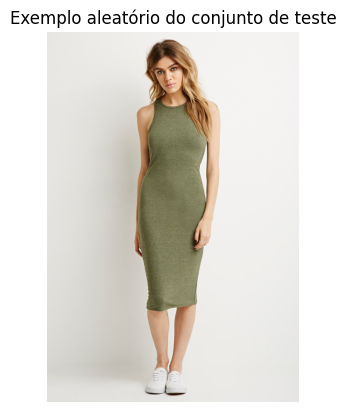

Legenda real:     This person is wearing a sleeveless tank top with solid color patterns and a three-quarter pants. The tank top is with cotton fabric and its neckline is round. The pants are with cotton fabric and solid color patterns. This lady wears a ring.
Legenda gerada:   The female is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric and its neckline is v-shape.
Score BLEU:       0.1994


In [ ]:
# Tokenizer padrão GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Gerar legenda
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


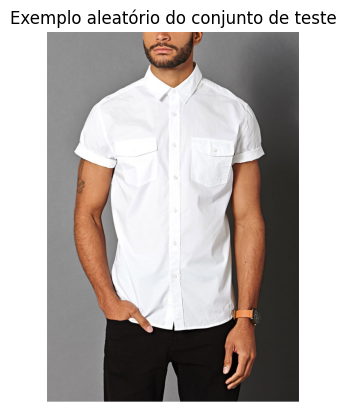

Legenda real:     This gentleman is wearing a short-sleeve T-shirt with solid color patterns. The T-shirt is with cotton fabric. The neckline of the T-shirt is lapel. There is an accessory on his wrist.
Legenda gerada:   The female wears a tank tank top with solid color patterns. The tank top is with cotton fabric and its neckline is suspenders. The female wears
Score BLEU:       0.2219


In [ ]:
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


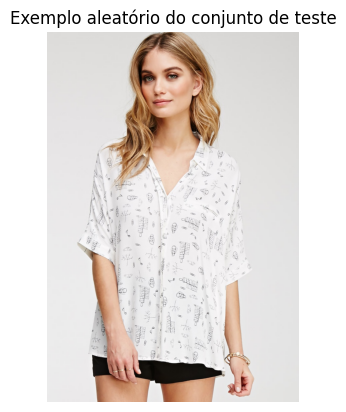

Legenda real:     This female is wearing a medium-sleeve shirt with graphic patterns. The shirt is with chiffon fabric. It has a lapel neckline. This female wears a three-point pants. The pants are with cotton fabric and pure color patterns. There is an accessory on her wrist. There is a ring on her finger.
Legenda gerada:   The female is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric and its neckline is v-shape.
Score BLEU:       0.0736


In [ ]:
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


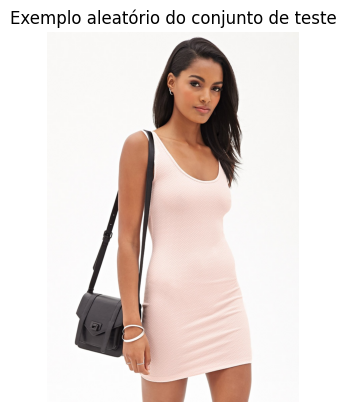

Legenda real:     The person wears a sleeveless tank top with pure color patterns and a three-point shorts. The tank top is with cotton fabric and its neckline is crew. The shorts are with cotton fabric and pure color patterns. The lady is wearing a ring on her finger. There is an accessory on her wrist.
Legenda gerada:   The female wears a long-sleeve sweater with striped patterns. The sweater is with cotton fabric and it has a round neckline. The outer clothing
Score BLEU:       0.0675


In [ ]:
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


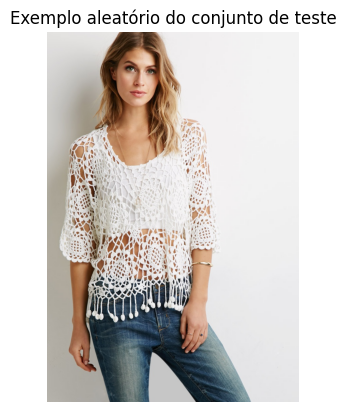

Legenda real:     The female wears a medium-sleeve shirt with graphic patterns. The shirt is with knitting fabric and its neckline is round. There is an accessory in his her neck. There is an accessory on her wrist. There is a ring on her finger.
Legenda gerada:   The female is wearing a sleeveless tank shirt with graphic patterns. The tank shirt is with cotton fabric and its neckline is crew. The female
Score BLEU:       0.1829


In [ ]:
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


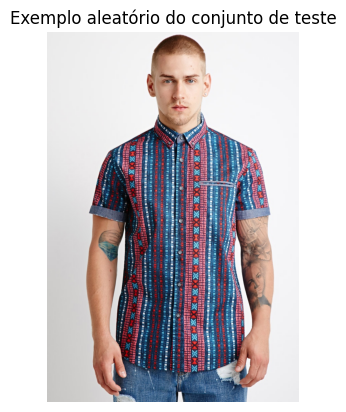

Legenda real:     This person wears a short-sleeve shirt with graphic patterns. The shirt is with cotton fabric. The neckline of the shirt is lapel.
Legenda gerada:   The female is wearing a sleeveless tank shirt with graphic patterns. The tank shirt is with cotton fabric and its neckline is crew. The female
Score BLEU:       0.3396


In [ ]:
visualizar_amostra_aleatoria_com_bleu(model, test_loader, tokenizer, device)


# Discussão Geral

Durante a execução do trabalho, foi possível exercitar os principais conceitos relacionados a redes neurais, como CNNs, codificadores (encoders), decodificadores (decoders) e a arquitetura encoder-decoder, todos abordados ao longo da disciplina. Além disso, o grupo desenvolveu de forma autônoma um pipeline completo para a tarefa de Image-to-Text, utilizando majoritariamente a biblioteca PyTorch. Um ponto especialmente positivo foi a oportunidade de aplicar a técnica de fine-tuning em modelos pré-treinados, o que permitiu compreender, na prática, como essa abordagem contribui para a adaptação do modelo a tarefas específicas.

Durante o desenvolvimento, diversos desafios surgiram, principalmente devido à inexperiência prévia do grupo com o tema. Em muitos momentos, optou-se por avançar de forma mais lenta, priorizando a compreensão dos fundamentos teóricos e das implementações técnicas. Ao final do projeto, foi possível observar uma evolução significativa na capacidade de implementar soluções completas com redes neurais profundas.

Outro desafio importante foi manter a produtividade frente à complexidade do ambiente de trabalho. O grupo enfrentou dificuldades com a manipulação de modelos, uso de GPU, gestão de ambientes virtuais e controle de versões dos modelos treinados, além das limitações de hardware disponíveis.

Quanto aos resultados, observou-se uma tendência de convergência da rede, o que demonstra um comportamento promissor do modelo. No entanto, para alcançar resultados mais expressivos, seria necessário dispor de maior tempo de treinamento e uma base de dados mais ampla. A substituição da CNN por uma arquitetura mais robusta ou pré-treinada, além da adoção de técnicas de otimização mais refinadas da função de perda, também se mostram caminhos viáveis para melhorar significativamente o desempenho do sistema.